In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FIX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,12.51,12.68,12.24,12.45,11.569341,263100
1,1/3/2013,12.50,12.62,12.42,12.55,11.662267,73500
2,1/4/2013,12.66,12.96,12.59,12.78,11.875998,102600
3,1/7/2013,12.69,12.70,12.59,12.66,11.764485,39600
4,1/8/2013,12.64,12.77,12.46,12.54,11.652973,32500


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 2472.700003.3, cost: 0.091143, total money: 5798.449987
epoch: 20, total rewards: 1556.690011.3, cost: 0.049520, total money: 6846.269994
epoch: 30, total rewards: 1096.140005.3, cost: 0.035179, total money: 7248.459993
epoch: 40, total rewards: 597.850000.3, cost: 0.025424, total money: 7560.939989
epoch: 50, total rewards: 521.009993.3, cost: 0.018688, total money: 7821.249984
epoch: 60, total rewards: 334.079995.3, cost: 0.013054, total money: 8109.689988
epoch: 70, total rewards: 247.249990.3, cost: 0.009633, total money: 8311.589983
epoch: 80, total rewards: 100.889987.3, cost: 0.003223, total money: 9071.579982
epoch: 90, total rewards: 81.409981.3, cost: 0.003491, total money: 8964.439976
epoch: 100, total rewards: 28.909964.3, cost: 0.007015, total money: 8405.639960
epoch: 110,

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 12.660000, total balance 9987.340000
day 4, sell 1 unit at price 12.540000, investment -0.947866 %, total balance 9999.880000,
day 7: buy 1 unit at price 12.590000, total balance 9987.290000
day 8, sell 1 unit at price 12.650000, investment 0.476564 %, total balance 9999.940000,
day 9: buy 1 unit at price 12.630000, total balance 9987.309999
day 10, sell 1 unit at price 12.430000, investment -1.583530 %, total balance 9999.740000,
day 15: buy 1 unit at price 12.720000, total balance 9987.020000
day 16, sell 1 unit at price 12.810000, investment 0.707548 %, total balance 9999.830000,
day 17: buy 1 unit at price 12.930000, total balance 9986.900000
day 18, sell 1 unit at price 12.980000, investment 0.386692 %, total balance 9999.879999,
day 21: buy 1 unit at price 13.010000, total balance 9986.869999
day 22: buy 1 unit at price 12.090000, total balance 9974.779999
day 23, sell 1 unit at price 12.250000, investment -5.841662 %, total balance 9987.029999,
day 24:

day 167: buy 1 unit at price 15.100000, total balance 9936.680001
day 168, sell 1 unit at price 15.420000, investment -5.224341 %, total balance 9952.100001,
day 169: buy 1 unit at price 15.200000, total balance 9936.900002
day 170, sell 1 unit at price 15.280000, investment -5.679018 %, total balance 9952.180001,
day 171, sell 1 unit at price 15.690000, investment -4.678005 %, total balance 9967.870001,
day 172: buy 1 unit at price 15.950000, total balance 9951.920001
day 173, sell 1 unit at price 15.970000, investment -1.358865 %, total balance 9967.890001,
day 174, sell 1 unit at price 15.990000, investment 5.894036 %, total balance 9983.880001,
day 179, sell 1 unit at price 16.469999, investment 8.355260 %, total balance 10000.350000,
day 180: buy 1 unit at price 16.620001, total balance 9983.730000
day 181, sell 1 unit at price 16.700001, investment 4.702200 %, total balance 10000.430000,
day 182, sell 1 unit at price 16.709999, investment 0.541506 %, total balance 10017.139999,
d

day 362: buy 1 unit at price 16.610001, total balance 9982.670005
day 367: buy 1 unit at price 16.000000, total balance 9966.670005
day 368: buy 1 unit at price 15.960000, total balance 9950.710005
day 369, sell 1 unit at price 15.970000, investment -3.968725 %, total balance 9966.680005,
day 370, sell 1 unit at price 15.740000, investment -5.237813 %, total balance 9982.420005,
day 374, sell 1 unit at price 15.910000, investment -0.562501 %, total balance 9998.330005,
day 375: buy 1 unit at price 15.800000, total balance 9982.530004
day 376, sell 1 unit at price 16.379999, investment 2.631573 %, total balance 9998.910004,
day 377: buy 1 unit at price 16.180000, total balance 9982.730003
day 378, sell 1 unit at price 16.330000, investment 3.354429 %, total balance 9999.060003,
day 381: buy 1 unit at price 15.960000, total balance 9983.100003
day 382: buy 1 unit at price 15.550000, total balance 9967.550003
day 383: buy 1 unit at price 15.550000, total balance 9952.000003
day 386, sell 

day 553: buy 1 unit at price 19.340000, total balance 9898.860005
day 554: buy 1 unit at price 19.559999, total balance 9879.300006
day 555, sell 1 unit at price 19.860001, investment 5.920003 %, total balance 9899.160006,
day 556: buy 1 unit at price 19.709999, total balance 9879.450007
day 557, sell 1 unit at price 19.740000, investment 4.721482 %, total balance 9899.190007,
day 558, sell 1 unit at price 19.830000, investment 4.533477 %, total balance 9919.020007,
day 559, sell 1 unit at price 20.010000, investment 1.780266 %, total balance 9939.030007,
day 560: buy 1 unit at price 19.670000, total balance 9919.360007
day 561, sell 1 unit at price 20.290001, investment 4.479922 %, total balance 9939.650008,
day 562: buy 1 unit at price 20.309999, total balance 9919.340009
day 563, sell 1 unit at price 21.180000, investment 9.513961 %, total balance 9940.520009,
day 564: buy 1 unit at price 21.040001, total balance 9919.480008
day 565, sell 1 unit at price 21.040001, investment 7.5664

day 729, sell 1 unit at price 31.570000, investment -0.972395 %, total balance 9970.940009,
day 730, sell 1 unit at price 32.459999, investment 3.672947 %, total balance 10003.400008,
day 732, sell 1 unit at price 32.419998, investment 4.749588 %, total balance 10035.820006,
day 735: buy 1 unit at price 32.340000, total balance 10003.480006
day 736: buy 1 unit at price 32.189999, total balance 9971.290008
day 737, sell 1 unit at price 33.130001, investment 10.988277 %, total balance 10004.420009,
day 738, sell 1 unit at price 33.610001, investment 3.927027 %, total balance 10038.030009,
day 739: buy 1 unit at price 33.709999, total balance 10004.320010
day 740: buy 1 unit at price 32.610001, total balance 9971.710010
day 743: buy 1 unit at price 30.730000, total balance 9940.980010
day 746: buy 1 unit at price 29.530001, total balance 9911.450009
day 747, sell 1 unit at price 29.030001, investment -9.816707 %, total balance 9940.480010,
day 749, sell 1 unit at price 28.379999, investme

day 935: buy 1 unit at price 30.389999, total balance 10059.360015
day 936, sell 1 unit at price 30.260000, investment -0.427770 %, total balance 10089.620015,
day 937: buy 1 unit at price 29.940001, total balance 10059.680015
day 939: buy 1 unit at price 29.299999, total balance 10030.380015
day 942: buy 1 unit at price 29.150000, total balance 10001.230016
day 943: buy 1 unit at price 28.959999, total balance 9972.270017
day 944, sell 1 unit at price 29.309999, investment -2.104212 %, total balance 10001.580016,
day 945, sell 1 unit at price 29.010000, investment -0.989758 %, total balance 10030.590016,
day 946, sell 1 unit at price 29.230000, investment 0.274442 %, total balance 10059.820016,
day 947, sell 1 unit at price 29.840000, investment 3.038678 %, total balance 10089.660016,
day 948: buy 1 unit at price 29.889999, total balance 10059.770017
day 950, sell 1 unit at price 29.100000, investment -2.643021 %, total balance 10088.870017,
day 955: buy 1 unit at price 27.900000, tot

day 1140, sell 1 unit at price 36.599998, investment -1.480493 %, total balance 10009.750028,
day 1141, sell 1 unit at price 36.700001, investment 1.944447 %, total balance 10046.450028,
day 1142, sell 1 unit at price 36.599998, investment 0.826444 %, total balance 10083.050027,
day 1147: buy 1 unit at price 36.150002, total balance 10046.900025
day 1148: buy 1 unit at price 36.450001, total balance 10010.450025
day 1150, sell 1 unit at price 36.700001, investment 2.945299 %, total balance 10047.150025,
day 1153: buy 1 unit at price 33.500000, total balance 10013.650025
day 1155: buy 1 unit at price 32.900002, total balance 9980.750024
day 1156, sell 1 unit at price 33.200001, investment -8.160444 %, total balance 10013.950025,
day 1157, sell 1 unit at price 33.349998, investment -8.504807 %, total balance 10047.300023,
day 1158, sell 1 unit at price 33.950001, investment 1.343286 %, total balance 10081.250024,
day 1159, sell 1 unit at price 33.599998, investment 2.127650 %, total bala

day 1363, sell 1 unit at price 47.099998, investment 15.018309 %, total balance 9371.500001,
day 1364, sell 1 unit at price 47.700001, investment 16.199760 %, total balance 9419.200002,
day 1366: buy 1 unit at price 48.150002, total balance 9371.050000
day 1367: buy 1 unit at price 47.450001, total balance 9323.599999
day 1368: buy 1 unit at price 47.450001, total balance 9276.149999
day 1370, sell 1 unit at price 47.900002, investment 17.835178 %, total balance 9324.050000,
day 1372, sell 1 unit at price 47.549999, investment 14.165660 %, total balance 9371.599999,
day 1373: buy 1 unit at price 47.900002, total balance 9323.699998
day 1374, sell 1 unit at price 48.599998, investment 16.407182 %, total balance 9372.299996,
day 1375: buy 1 unit at price 48.049999, total balance 9324.249997
day 1379: buy 1 unit at price 45.950001, total balance 9278.299996
day 1381: buy 1 unit at price 45.950001, total balance 9232.349995
day 1382, sell 1 unit at price 45.750000, investment 9.319000 %, t

day 1532, sell 1 unit at price 47.849998, investment -7.856734 %, total balance 9183.479985,
day 1534, sell 1 unit at price 48.590000, investment -9.143604 %, total balance 9232.069985,
day 1536, sell 1 unit at price 48.090000, investment -18.074958 %, total balance 9280.159985,
day 1539: buy 1 unit at price 49.779999, total balance 9230.379987
day 1540, sell 1 unit at price 50.000000, investment -15.540542 %, total balance 9280.379987,
day 1541, sell 1 unit at price 50.660000, investment -12.383258 %, total balance 9331.039986,
day 1542: buy 1 unit at price 51.020000, total balance 9280.019986
day 1543: buy 1 unit at price 51.639999, total balance 9228.379987
day 1544, sell 1 unit at price 51.950001, investment -7.414008 %, total balance 9280.329987,
day 1545: buy 1 unit at price 54.439999, total balance 9225.889989
day 1546: buy 1 unit at price 54.349998, total balance 9171.539990
day 1547: buy 1 unit at price 54.090000, total balance 9117.449990
day 1548: buy 1 unit at price 53.5900

day 1702: buy 1 unit at price 42.630001, total balance 8981.319978
day 1703: buy 1 unit at price 41.740002, total balance 8939.579976
day 1704, sell 1 unit at price 41.820000, investment -16.759558 %, total balance 8981.399976,
day 1706, sell 1 unit at price 43.490002, investment -14.102309 %, total balance 9024.889977,
day 1708, sell 1 unit at price 43.320000, investment -15.374095 %, total balance 9068.209977,
day 1709: buy 1 unit at price 43.310001, total balance 9024.899976
day 1710, sell 1 unit at price 44.169998, investment -13.544729 %, total balance 9069.069974,
day 1711, sell 1 unit at price 45.150002, investment -13.439414 %, total balance 9114.219975,
day 1713, sell 1 unit at price 46.110001, investment -12.835540 %, total balance 9160.329976,
day 1714: buy 1 unit at price 46.849998, total balance 9113.479977
day 1715: buy 1 unit at price 47.080002, total balance 9066.399976
day 1716, sell 1 unit at price 51.570000, investment -2.366528 %, total balance 9117.969975,
day 1717

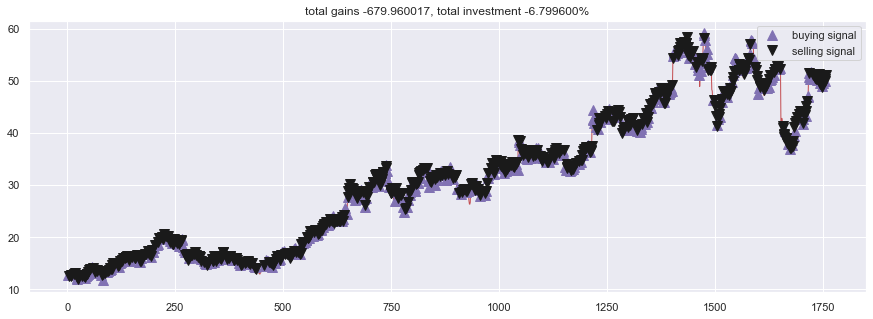

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()